<center><h1> Mini-batch Regression Neural Network Predicting for Median Housing Prices in the 1990 California, U.S. Census</h1></center> 

<center><h4> Nyasha M, 15 May 2021 </h4></center>
<p>&nbsp;</p>

**Background:**
This dataset comes from Chapter 2 of Aurélien Géron's book 'Hands-On Machine learning with Scikit-Learn and TensorFlow' (2017). The dataset itself contains various information on 1426 households from the 1990 California, U.S. census. In total, the dataset contains 20,640 observations and 9 variables as well as some missing data. 

The .csv file used in this project came from the following webpage by Luís Torgo at the University of Porto: https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html. His main webpage is located here: https://www.dcc.fc.up.pt/~ltorgo/.

**Objective:**
The goal of this notebook was to predict median house values ($) in the California 1990 census dataset by performing regression with an artificial Neural Network.

**Methods:**
Regression was done with a 3-layer neural network with He-initialized weights. The model used mini-batch gradient descent with gradient clipping and cross-validation while training. Batch normalization and dropout were also used to facilitate learning and add regularization to the model, respectively. Some missing data analysis was performed pre-modeling.

---
### Package imports

In [456]:
import warnings;
warnings.filterwarnings('ignore');

In [65]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Missing data analysis
import missingno as msno

# Enable R functions
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
rpy2.robjects.numpy2ri.activate()

# Modeling
import tensorflow as tf
import sklearn.preprocessing as preprocess
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

### Data Exploration and Pre-processing

In [461]:
df = pd.read_csv('housing.csv')
df.head(4)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY


In [462]:
df.shape

(20640, 10)

In [463]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

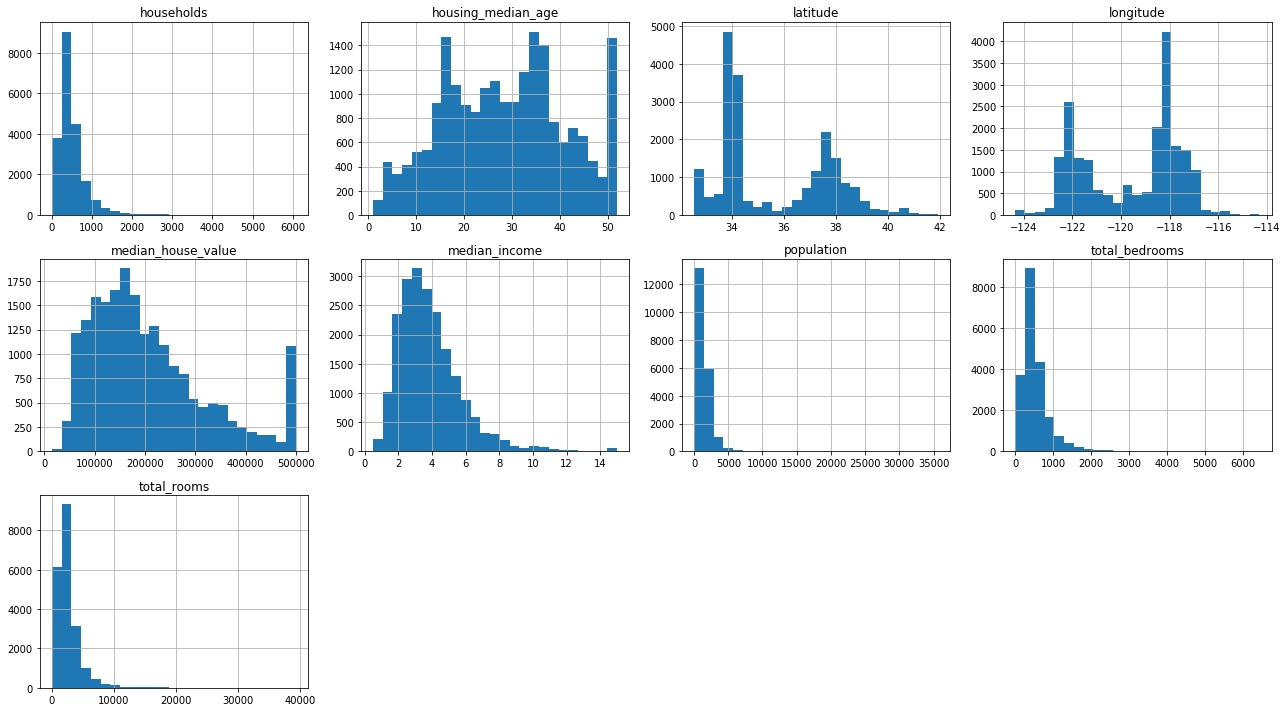

In [464]:
df.hist(figsize=(18,10), layout=(3,4), bins=25) # Some bimodal distributions.
plt.tight_layout()
plt.show()

Is there missing data? If so, where, and what does the surrounding data look like?

In [10]:
df[df.isna().any(axis=1)]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
290,-122.16,37.77,47.0,1256.0,NaN,570.0,218.0,4.3750,161900.0,NEAR BAY
341,-122.17,37.75,38.0,992.0,NaN,732.0,259.0,1.6196,85100.0,NEAR BAY
538,-122.28,37.78,29.0,5154.0,NaN,3741.0,1273.0,2.5762,173400.0,NEAR BAY
563,-122.24,37.75,45.0,891.0,NaN,384.0,146.0,4.9489,247100.0,NEAR BAY
696,-122.10,37.69,41.0,746.0,NaN,387.0,161.0,3.9063,178400.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20267,-119.19,34.20,18.0,3620.0,NaN,3171.0,779.0,3.3409,220500.0,NEAR OCEAN
20268,-119.18,34.19,19.0,2393.0,NaN,1938.0,762.0,1.6953,167400.0,NEAR OCEAN
20372,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,410700.0,<1H OCEAN
20460,-118.75,34.29,17.0,5512.0,NaN,2734.0,814.0,6.6073,258100.0,<1H OCEAN


Examining the missing data pattern. This might inform of us what imputation method we might be able to use on the data. It looks like the data might follow a missing completely at random (MCAR) pattern. Let's check:

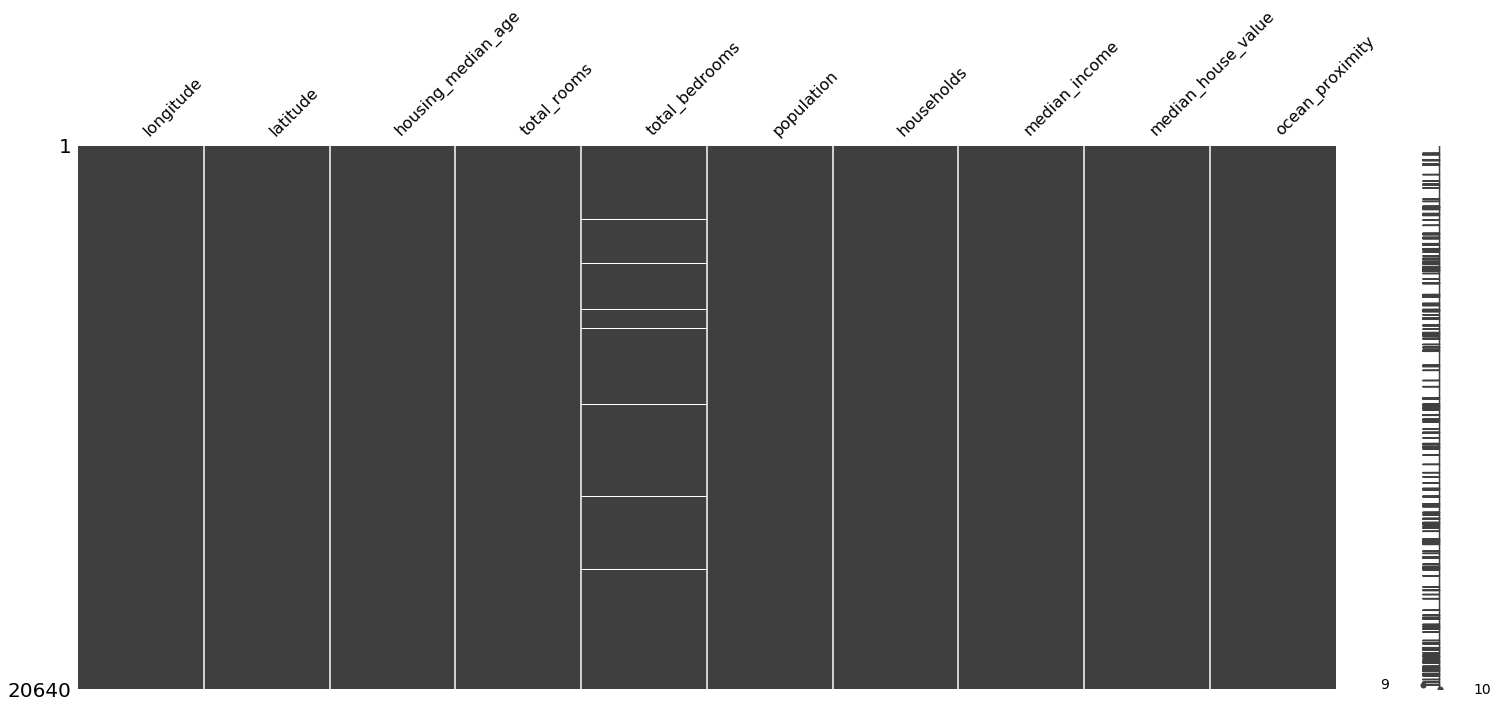

In [15]:
msno.matrix(df) # white strips indicate missing data
plt.show()

In [465]:
# Add a flag to indicate where the data is missing, to enable us to do some missing data analyses.
df['missing_flag'] = (df.total_bedrooms.isna()==True).astype(int) 

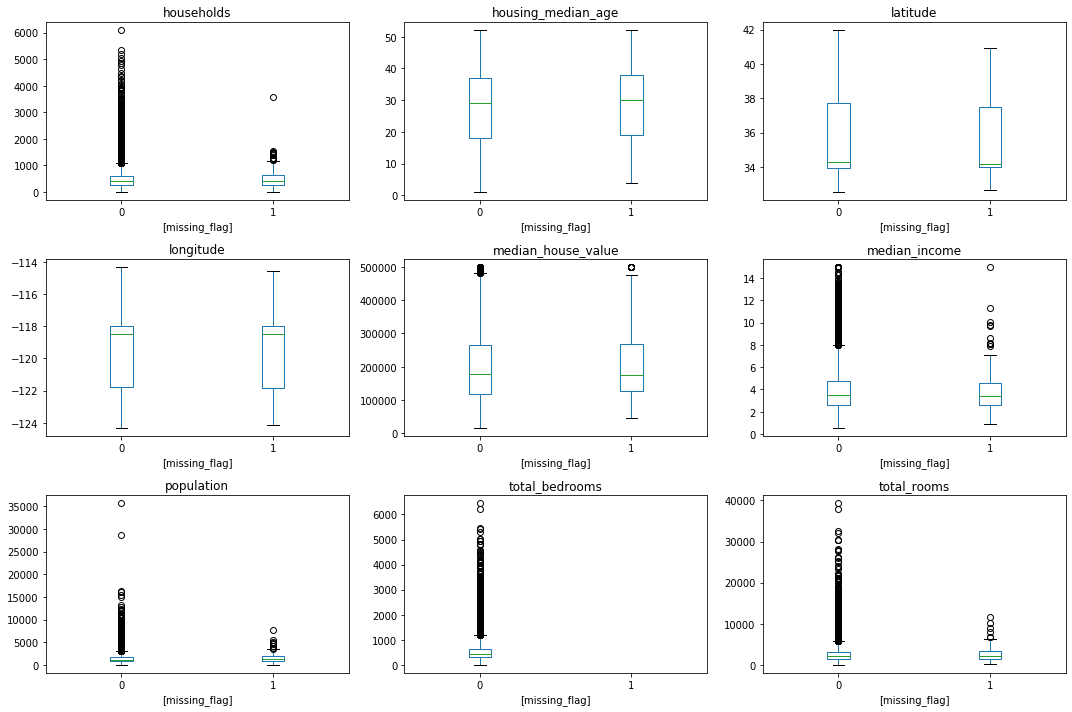

In [466]:
fig, axs = plt.subplots(3,3, figsize=(15,10), sharey=False)

df.boxplot(by='missing_flag', ax=axs, grid=False)
plt.suptitle("")
plt.tight_layout()
plt.show()

In [467]:
(df.isnull().sum().sum()/df.isnull().count().sum())*100

0.09117336152219874

Out of all observations, <0.10% of the data is missing. Let's examine the distribution of missing data along our categorical variable (`ocean_proximity`), however, before we proceed with assuming that the missing data pattern for `total_bedrooms` is truly MCAR.

#### Examining `ocean_proximity` for its distribution of missing values

In [60]:
print(df.ocean_proximity.value_counts(dropna=False), "\n\nNumber of unique values: ", 
      len(df.ocean_proximity.value_counts().unique()))

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64 

Number of unique values:  5


In [61]:
stats = importr('stats') # import R package 'stats'

In [92]:
crosstab_cat = pd.crosstab(df['ocean_proximity'], df['missing_flag'])

# Compute proportions of missing data for each ocean_proximity class and add to count table
crosstab_cat['percent_col_0'] = 100*(crosstab_cat[0]/df['missing_flag'].value_counts()[0])
crosstab_cat['percent_col_1'] = 100*(crosstab_cat[1]/df['missing_flag'].value_counts()[1])

crosstab_cat

missing_flag,0,1,percent_col_0,percent_col_1
ocean_proximity,,,,
<1H OCEAN,9034,102,44.212793,49.275362
INLAND,6496,55,31.791709,26.570048
ISLAND,5,0,0.024470,0.000000
NEAR BAY,2270,20,11.109480,9.661836
NEAR OCEAN,2628,30,12.861547,14.492754


In [95]:
print(stats.fisher_test(np.array(crosstab_cat[0]), np.array(crosstab_cat[1]))) # Significant, but massive sample sizes



	Fisher's Exact Test for Count Data



data:  structure(c(9034L, 6496L, 5L, 2270L, 2628L), .Dim = 5L) and structure(c(102L, 55L, 0L, 20L, 30L), .Dim = 5L)

p-value = 1

alternative hypothesis: two.sided





The Fischer's Exact test was statistically significant, but we also have massive sample sizes. Looking at the frequencies for each category of `ocean_proximity` where there is missing data versus non-missing data, it doesn't appear as though there is a significant association between the missing data and `ocean_proximity`. It really does appear as though the data is MCAR. Furthermore, we also have a very low percentage of missing data in the dataset. Therefore, we will proceed with a complete case analysis. 

In [470]:
df = df[df.total_bedrooms.isna()==False] # Drop the rows with missing data.
df = df.reset_index(drop=True)

df.tail() # Showing the end of the dataframe.

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,missing_flag
20428,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,0
20429,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,0
20430,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,0
20431,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,0
20432,-121.24,39.37,16.0,2785.0,616.0,1387.0,530.0,2.3886,89400.0,INLAND,0


### OneHotEncoding and train-test splits

In [471]:
x, y = df.loc[: , df.columns!='median_house_value'], df['median_house_value']

In [472]:
# OneHotEncode 'ocean_proximity'.
enc = preprocess.OneHotEncoder()
trans = enc.fit_transform(x[['ocean_proximity']]).toarray()
trans_df = pd.DataFrame(trans, columns = enc.get_feature_names(['ocean_proximity']))

x = pd.concat([x, trans_df], axis=1)
x = x.drop(['ocean_proximity', 'missing_flag'], axis = 1)
x.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,0.0,0.0,0.0,1.0,0.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,0.0,0.0,0.0,1.0,0.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,0.0,0.0,0.0,1.0,0.0


In [473]:
seed = 100
test_size = 0.20

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed) # train-test split

#### Feature Standardization

In [475]:
sc = preprocess.MinMaxScaler(feature_range = (0,1)) # NN like normalized data

# only perform feature scaling on the non-dummy variables.
x_train = sc.fit_transform(x_train.loc[:,:'median_income']) 
x_test = sc.transform(x_test.loc[:,:'median_income'])

In [476]:
y_train = sc.fit_transform(np.array(y_train).reshape(-1,1)) 

### Creating the neural network
Here is where we add the layers to our neural network for regression while incorporating batch normalization, He-initialized weights, mini-batch gradient descent, and gradient clipping. 

Note that I played around with several of the model's parameters and hyperparameters before settling on these ones!

In [477]:
def make_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units= 40, activation='relu', kernel_initializer='he_normal'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Dense(units= 40, activation='relu', kernel_initializer='he_normal'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Dense(units= 40, activation='relu', kernel_initializer='he_normal'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Dense(1, activation='linear'))
    model.add(tf.keras.layers.BatchNormalization())
    # Compile model
    sgd = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9, clipvalue=5.0)
    #model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['mean_squared_error'])
    return model

In [478]:
model = make_model()

Running the model with cross-validation.

In [491]:
results = model.fit(x_train, y_train, epochs=90, batch_size=32, validation_split=0.2, verbose=0)

In [480]:
y_pred = model.predict(x_test)
y_pred = sc.inverse_transform(y_pred) # Remember, trained (and predicted) on standardized housing prices

How does the distribution of our predicted median house values compare to that of the test set's?

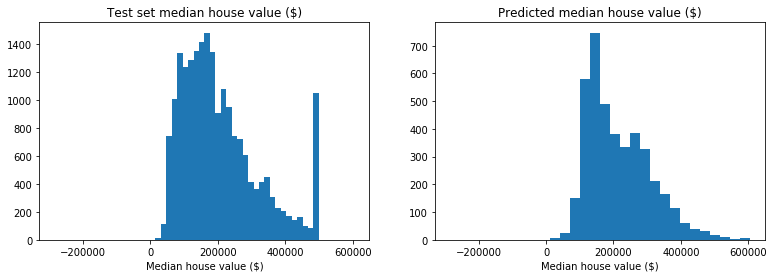

In [481]:
fig, axs = plt.subplots(1,2, figsize=(13,4), sharex=True)
axs[0].hist(df.median_house_value, bins=30)
axs[0].set_title('Test set median house value ($)'), axs[0].set_xlabel('Median house value ($)')
axs[1].hist(y_pred, bins=30)
axs[1].set_title('Predicted median house value ($)'), axs[1].set_xlabel('Median house value ($)')
plt.show()

How did the loss of the model (mean squared error [MSE]) change over time? 

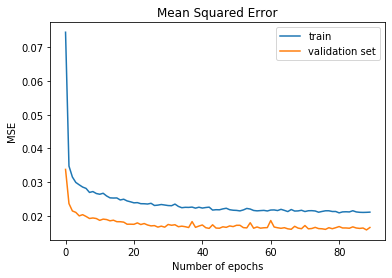

In [488]:
plt.plot(results.history['loss'], label='train')
plt.plot(results.history['val_loss'], label='validation set')
plt.title('Mean Squared Error'), plt.legend(), plt.xlabel('Number of epochs'), plt.ylabel('MSE')
plt.show()

Now evaluating the MSE of our model when it's fitted to the test set. 

In [483]:
train_mse = model.evaluate(x_train, y_train, verbose=1)
test_mse = model.evaluate(x_test, y_test, verbose=1)

128/128 [==============================] - 0s 1ms/step - loss: 56108101632.0000 - mean_squared_error: 56108101632.0000


In [484]:
print(f'Train MSE: {np.round(train_mse,3)[0]}, test MSE: {np.round(test_mse,3)[0]}')

Train MSE: 0.017, test MSE: 56108101632.0


The MSE here looks highly comparable to the validation error (MSE) we got at the end of our training. This is good. Now we can plot the residuals from our model as well as compute the root mean squared error (RMSE) for more information.

In [485]:
residuals = np.array(y_test).shape-y_pred

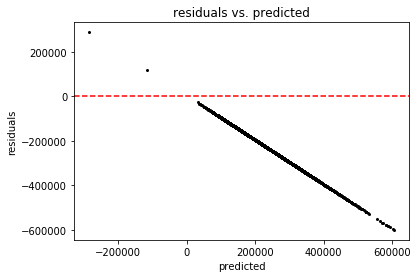

In [486]:
plt.scatter(y_pred, residuals, color='black', s=4)
plt.xlabel('predicted'), plt.ylabel('residuals'), plt.title('residuals vs. predicted')
plt.axhline(y=0, color='red', linestyle='dashed')
plt.show()

In [487]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Average error in predicting house prices: +-{round(rmse, 3)} off from the true median house price.")

Average error in predicting house prices: +-64332.406 off from the true median house price.


Checking the distributions of our target variable (median house value) in both our training and test sets.

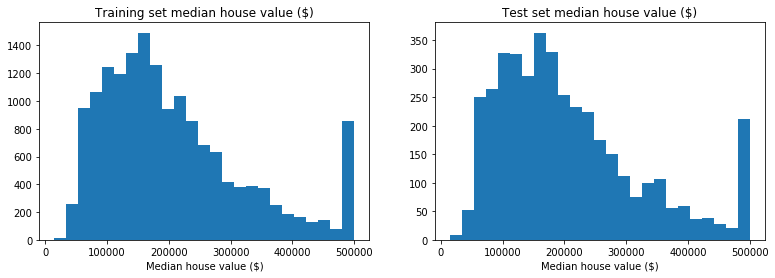

In [454]:
fig, axs = plt.subplots(1,2, figsize=(13,4), sharex=True)
axs[0].hist(sc.inverse_transform(y_train), bins=25)
axs[0].set_title('Training set median house value ($)'), axs[0].set_xlabel('Median house value ($)')
axs[1].hist(y_test, bins=25)
axs[1].set_title('Test set median house value ($)'), axs[1].set_xlabel('Median house value ($)')
plt.show()